# DSI-10 Project 3 

1. [Problem Statement](#Problem-Statement)
    * [Goal](#Goal)
    * [Tasks](#Tasks)
      
2. [Imports](#IMPORTS)
3. [Data Collection](#Data-Collection)
4. [Data Cleaning & EDA](#Custom-functions-for-data-cleaning-and-EDA)
5. [Parameter Combinations](#PARAMETER-COMBINATIONS)
5. [Running all parameter combinations](#Running-tests-for-all-parameter-combinations-to-see-which-one-scored-the-best)
6. [Visualizing Models](#VISUALIZING-MODELS)
7. [Lemmatizing](#LEMMATIZING)   
8. [Stemmer](#STEMMER)
9. [Running tests for 1000 posts](#Running-tests-for-all-parameter-combinations-to-see-which-one-scored-the-best-1000)
6. [Final model](#FINAL-MODEL-USED-FOR-CLASSIFYING-DEBATE-EVOLUTION)
7. [Investigate r/DebateEvolution](#INVESTIGATING-THE-DebateEvolution-subreddit.-Checking-which-side-the-topics-are-leaning-using-my-best-model-so-far)

# Problem Statement

# To allow users/moderators to classify posts on various channels based on their preferences

### E.g. A science moderator may want to keep the conversation focus on the science side where as a Creationist moderator may want to keep the conversation focus on the creationist side

### Taks
1. Using [Pushshift's](https://github.com/pushshift/api) API, to collect posts from two subreddits.
2. Then use Natural Language Processing to train a classifier on which subreddit a given post came from. This is a binary classification problem.

## Tasks

* Download recent `1000` posts from `r/evolution`  and set the `Target value` as `0` 
* Download recent `1000` posts from `r/Creation`   and set the `Target value` as `1`
* Study the posts from both the subreddits. Combine comments to increase the data set.
* Combine both the posts as one data set. Then allot `70%` as `train data` set and `30%` as test.
* EDA - using different data visualizations
* Use NLP to tokenize, process (lemmatize/stemming/stopwords) and extract meaningful words to define a `quanitative language pattern shape` from both the posts. This will enable a model to predict which post came from which reddit.
* Train a model to 1st predict 1 and 0 
* Use mutiple predictor model combinations to classify the data and choose the best estimator by evaluating each model using classifier metrics like accuracy , sensitivity , specificity , precision, mis calculation and roc acu 
* Download recent `1000` posts from DebateEvolution
* Use the best estimator to identify posts from DebateEvolution as `pro evolution` or `pro Creation & Intelligent Design`. This part is an `unsupervised prediction` to see if the model is able to `detect a language pattern`.
* Present findings

# IMPORTS

In [2]:
import pandas as pd
import regex as re
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.metrics import accuracy_score 
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB 

import time

from IPython.display import display, HTML
from sklearn.naive_bayes import GaussianNB
from sklearn.base import TransformerMixin
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer

sns.set(style='darkgrid')
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore",category=DeprecationWarning)



In [3]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

# Data Collection
     
 * [/r/evolution](https://www.reddit.com/r/evolution/)
 * [/r/Creation](https://www.reddit.com/r/Creation/)
 * [/r/DebateEvolution](https://www.reddit.com/r/DebateEvolution/)

##### Downloaded recent 2000 `posts` and  2000 `comments` from 3 subreddits

  [Link to python file used for data download](./classification_data/download_subreddits.py)

# Custom functions for data cleaning and EDA

In [4]:
#clean words and remove stop words from english language
def clean_words_remove_stop_words(s):
    
    if type(s) is not str:
        return str(" ")
    
    # Use regular expressions to do a find-and-replace
    words = re.sub("[^a-zA-Z]",           # The pattern to search for
                          " ",            # The pattern to replace it with
                      s)   # The text to search
    
    list_words = words.split(" ")
    
    #
    meaningful_words = [w for w in  list_words if w not in stopwords.words('english')]
    
    #remove additional words
    remove_more_words = ["https", "edu", "com", "http", "org", 'www', 'amp']
    
    #return a meaning ful string of words
    return ",".join([w for w in meaningful_words if w not in remove_more_words])

# Function to read files from dataset folder
def read_dataset(subreddit, end_point, run):
    return pd.read_csv("./datasets/"+subreddit+"_"+ end_point + "_"+ run+ ".csv")

In [6]:
# read data, clean data and resave it
def read_clean_resave():
    for i in range(1,4):
        run = str(i)
        subreddits = ["evolution", "creation", "DebateEvolution"]
        
        for sub in subreddits:
            sub_df = read_dataset(sub, "submission", run)
            comm_df = read_dataset(sub, "comment", run)
                
            comm_df["id"] = comm_df["link_id"].str.replace("t3_","")
            comm_df["body"] = comm_df["body"].str.lower()
            sub_df["title"] = sub_df["title"].str.lower()
            sub_df["selftext"] = sub_df["selftext"].str.lower()
        

            comm_df["body"] = comm_df["body"].map(clean_words_remove_stop_words)
            sub_df["title"] = sub_df["title"].map(clean_words_remove_stop_words)
            sub_df["selftext"] = sub_df["selftext"].map(clean_words_remove_stop_words)

            comment_dict = {x:"" for x in comm_df["id"].unique()}
            
            for i,b in enumerate(comm_df["body"]):
                comment_dict[comm_df.loc[i, "id"]] += b
                
            sub_df["comment"] = " "
            for idx in comment_dict:
                sub_df.loc[sub_df["id"] == idx,"comment"] = comment_dict[idx]
                
            #save cleaned data back to the folder
            sub_df.to_csv("./datasets/"+ sub+ "_sub_clean_"+ run + ".csv", index=False)
 
    
#Uncomment only if the data needs to be recleaned
# read_clean_resave()
print("Done")

Done


##### PARAMETER COMBINATIONS

In [5]:
## List of all the parameters that will try on the data
all_params = {1:{ "Pipeline" : [ ('vectorizer', CountVectorizer()),
                    ('classifier', LogisticRegression(random_state=42))],
     "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                       'vectorizer__ngram_range': [(1,3),(1,4)],
                       'vectorizer__stop_words': ['english'],
                       'vectorizer__min_df':[1],
                       'vectorizer__max_df':[1.0],
                       'classifier__penalty': ['l1', 'l2'],
                       'classifier__C': [0.01, 0.1, 1, 10],
                       'classifier__max_iter':[500,100]
                    },
 },
 2:{"Pipeline" : [ ('vectorizer', CountVectorizer()),
                    ('classifier', MultinomialNB())],
    "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                      'vectorizer__ngram_range': [(1,3),(1,4)],
                      'vectorizer__stop_words': ['english'],
                      'vectorizer__min_df':[1],
                      'vectorizer__max_df':[1.0] 
                    },
 },
 3:{"Pipeline" : [ ('vectorizer', CountVectorizer()),
                    ('classifier', KNeighborsClassifier())],
    "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                      'vectorizer__ngram_range': [(1,3),(1,4)],
                      'vectorizer__stop_words': ['english'],
                      'vectorizer__min_df':[1],
                      'vectorizer__max_df':[1.0],
                      'classifier__n_neighbors':[1, 5, 10, 20],
                      'classifier__p':[1,2]
                    },
 },
 4:{ "Pipeline" : [ ('vectorizer', TfidfVectorizer()),
                    ('classifier', LogisticRegression(random_state=42))],
     "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                       'vectorizer__ngram_range': [(1,3),(1,4)],
                       'vectorizer__stop_words': ['english'],
                       'vectorizer__min_df':[1],
                       'vectorizer__max_df':[1.0],
                       'classifier__penalty': ['l1', 'l2'],
                       'classifier__C': [0.01, 0.1, 1, 10],
                       'classifier__max_iter':[500,100]
                    },
 },
 5:{"Pipeline" : [ ('vectorizer', TfidfVectorizer()),
                   ('to_dense', DenseTransformer()),
                   ('classifier', GaussianNB())],
    "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                      'vectorizer__ngram_range': [(1,3),(1,4)],
                      'vectorizer__stop_words': ['english'],
                      'vectorizer__min_df':[1],
                      'vectorizer__max_df':[1.0] 
                    },
 },
 6:{"Pipeline" : [ ('vectorizer', TfidfVectorizer()),
                    ('classifier', KNeighborsClassifier())],
    "hyper_params": { 'vectorizer__max_features': [1000, 3000, 5000],
                      'vectorizer__ngram_range': [(1,3),(1,4)],
                      'vectorizer__stop_words': ['english'],
                      'vectorizer__min_df':[1],
                      'vectorizer__max_df':[1.0],
                      'classifier__n_neighbors':[1, 5, 10, 20],
                      'classifier__p':[1,2]
                    },
 },
}

# all_params

In [6]:
def get_bold(x):
    open_tag_bold = "\033[1m"
    close_tag_bold = "\033[0m"
    return open_tag_bold + str(x) + close_tag_bold

# display scores 
def display_scores(scores, no_of_posts):
    
    print("\nMetrics for {} posts".format(get_bold(no_of_posts)))
    df = pd.DataFrame(scores, index=list(range(1,4)))
    df = df.sort_values(by="Accuracy", ascending=True)
#     display(df)
    display(HTML(df.to_html()))
#     sns.set(style="darkgrid")
    df["Feature Set"] = df.index
    nrows = 1 # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=8, figsize=(18,3)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    col_list = ["Accuracy", "Mis Calculations","ROC AUC","Sensitivity","Specificity","Precision", "Test Scores","Train Scores"]
    col_colr = ["blue", "slategray", "green", "sienna", "teal", "firebrick", "lightseagreen", "mediumorchid"]
    for i, column in enumerate(col_list): # Gives us an index value to get into all our lists
        sns.scatterplot(df[column], df["Feature Set"],marker="o", size=df[column], legend=False, facecolor=col_colr[i], edgecolor=col_colr[i], ax=ax[i])
        ax[i].set_ylabel("");

#highlight minimum value form the data frame
def highlight_min(s):    
    is_min = s == s.min()
    return ['background-color: lightgreen' if v else '' for v in is_min]

#highlight max value from the data frame
def highlight_max(s):    
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]


#combine full row into a single row
def get_full_row(data, features):
    data["full_row"] = ""
    for col in features:
        data["full_row"] = data["full_row"] + "," + data[col].astype(str)
        

#return best estimator results
def get_score_data(results, X_train, X_test, y_train,y_test):
    output = []
    sub_scores = {}
    
    model = results.best_estimator_
    
    #confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, model.predict(X_test)).ravel()
    
    ##calulating accuracy
#     accuracy = (tp + tn) / (tp + fp + tn + fn)
    accuracy = round(accuracy_score(y_test, model.predict(X_test)),2)
    
    #calculating Misclassification Rate
    mis_calcuations = 1 - accuracy
    
    #calculating sensitivity
    sensitivity = tp / (tp + fn)

    #calculating specificity
    specificity = tn / (tn + fp)

    #calculating precision
    precision = tp / (tp + fp)
    
    #to predict roc_auc_score
    pred_proba = [i[1] for i in model.predict_proba(X_test)]

    pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})
    
    #For returning results from the best estimator
    #1. best score
    output.append(round(results.best_score_,2))
    
    #2.best params
    output.append(results.best_params_)
    
    #No of 0's and 1's in test
    sub_scores.update({"No of evolution posts": y_test[y_test == 0].count()})
    sub_scores.update({"No of Creation posts": y_test[y_test == 1].count()})
    
    #No of 0's and 1's predicted
    df = pd.DataFrame({"Preds": model.predict(X_test)})
    sub_scores.update({"No of predicted evolution posts": df.groupby("Preds")["Preds"].value_counts()[0].values[0]})
    sub_scores.update({"No of predicted creations posts": df.groupby("Preds")["Preds"].value_counts()[1].values[0]})
    
    #baseline
    sub_scores.update({"Baseline accuracy%": round(y_test.value_counts(normalize=True)[0],2)})
    
    #3.Train Score
    sub_scores.update({"Train Scores": round(model.score(X_train,y_train),2)})
    
    #4.Test Score
    sub_scores.update({"Test Scores": round(model.score(X_test,y_test),2)})
    
    #5.Accuracy
    sub_scores.update({"Accuracy": accuracy})
    
    #6.Mis Calculations
    sub_scores.update({"Mis Calculations": round(mis_calcuations,2)})

    #7.Sensitivity
    sub_scores.update({"Sensitivity": round(sensitivity,2)})
    
    #8.Specificity
    sub_scores.update({"Specificity": round(specificity,2)})

    #9.Precision
    sub_scores.update({"Precision": round(precision,2)})

    #9.ROC AUC
    sub_scores.update({"ROC AUC": round(round(roc_auc_score(pred_df['true_values'], pred_df['pred_probs']),2))})
    
    10.
    if model.score(X_train,y_train) > model.score(X_test,y_test):
        sub_scores.update({"Fit Type":"Overfit"})
    else:
        sub_scores.update({"Fit Type":"Underfit"})
        
    output.append(sub_scores)
    
    return output
    
    
    

#simple model,fit,evaluate, and return a list of best estimators and 
def model_fit_score(X, y, best_scores, feature_set_no):
     
        #Step 1 : split the data into test/train
        X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

        for param in all_params:

            pipe = Pipeline(all_params[param]["Pipeline"])
            hyper_params = all_params[param]["hyper_params"]
             
            # Perform Grid Search
            gridcv = GridSearchCV(pipe, 
                                  param_grid=hyper_params,
                                  cv = 5,
                                  scoring = "accuracy")
            #results
            results = gridcv.fit(X_train, y_train)
            best_scores[param] = get_score_data(results, X_train, X_test, y_train,y_test)
            #wait for 5 seconds until moving on
            time.sleep(5)
            print("Round {} complete for feature set {}".format(param, feature_set_no))
        
        return best_scores
            
    
#combine two subreddits
def combine(subreddit1, subreddit2):
    all_data_df = pd.concat((subreddit1, subreddit2), axis=0)
    sub1 = subreddit1["subreddit"].unique()[0]
    sub2 = subreddit2["subreddit"].unique()[0]
    
    all_data_df["y"] = all_data_df["subreddit"].map({sub1: 0, sub2: 1})
    
    return all_data_df

         
def lemmatize(s):
    list_words = s.split(",")
    lemmatizer = WordNetLemmatizer()
    return ','.join([lemmatizer.lemmatize(word) for word in list_words])

def stemmer(s):
    list_words = s.split(",")
    stemmer = PorterStemmer()
    return ','.join([stemmer.stem(word) for word in list_words])

feature_sets={"1": ["title"],
              "2": ["title", "selftext"],
              "3": ["title", "selftext", "comment"],
             }


#EDA for each run
def get_best_scores_params(run):
    evolution_sub_clean_df = pd.read_csv("./datasets/evolution_sub_clean_" + run+ ".csv")
    creation_sub_clean_df = pd.read_csv("./datasets/creation_sub_clean_" + run + ".csv")
    all_data_df = combine(evolution_sub_clean_df, creation_sub_clean_df)    

    
    best_scores = {x:{y:[] for y in all_params} for x in feature_sets}

    for features in feature_sets:
        get_full_row(all_data_df, feature_sets[features])
        model_fit_score(all_data_df["full_row"], all_data_df["y"], best_scores[features], features)

            
    return best_scores

# Running tests for all parameter combinations to see which one scored the best 

In [20]:
##Running all parameters for 100 Posts from evolution and 100 Posts from creating , including 100 comments each as well
best_scores = get_best_scores_params("1")

Round 1 complete for feature set 1
Round 2 complete for feature set 1
Round 3 complete for feature set 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Round 4 complete for feature set 1
Round 5 complete for feature set 1
Round 6 complete for feature set 1
Round 1 complete for feature set 2
Round 2 complete for feature set 2
Round 3 complete for feature set 2
Round 4 complete for feature set 2
Round 5 complete for feature set 2
Round 6 complete for feature set 2
Round 1 complete for feature set 3
Round 2 complete for feature set 3
Round 3 complete for feature set 3
Round 4 complete for feature set 3
Round 5 complete for feature set 3
Round 6 complete for feature set 3


In [21]:
metrics_dict = {x:{y:None for y in all_params} for x in feature_sets}
miss_calc_dict = {x:{y:None for y in all_params} for x in feature_sets}

In [22]:
for features in feature_sets:
    for params in all_params:
        metrics_dict[features][params] = best_scores[features][params][0]
for features in feature_sets:
    for params in all_params:
        miss_calc_dict[features][params] = best_scores[features][params][2]['Mis Calculations']

### FEATURE SETS

In [24]:
print("Feature Sets: Feature combination used to train each model (in all 7 models) and evaluate them")
print("\n")
for x in range(1,4):
    lst = feature_sets[str(x)]
    lst.sort()
    print("{}. {}".format(x, ", ".join(lst)))

Feature Sets: Feature combination used to train each model (in all 7 models) and evaluate them


1. title
2. selftext, title
3. comment, selftext, title


### In the below matrix:

   [Columns](#FEATURE-SETS)  Represent the `feature sets`
   
   [Rows](#PARAMETER-COMBINATIONS)  Represent the `parameter combinations`

In [25]:
pd.DataFrame(metrics_dict).style.apply(highlight_max)

,1,2,3
1,0.7,0.77,0.77
2,0.72,0.75,0.76
3,0.6,0.63,0.66
4,0.71,0.78,0.81
5,0.69,0.64,0.68
6,0.69,0.77,0.8


In [26]:
##best score from the above board, looking at the Scores in details
best_scores["3"][4]

[0.81,
 {'classifier__C': 0.01,
  'classifier__max_iter': 500,
  'classifier__penalty': 'l2',
  'vectorizer__max_df': 1.0,
  'vectorizer__max_features': 3000,
  'vectorizer__min_df': 1,
  'vectorizer__ngram_range': (1, 4),
  'vectorizer__stop_words': 'english'},
 {'No of evolution posts': 33,
  'No of Creation posts': 33,
  'No of predicted evolution posts': 38,
  'No of predicted creations posts': 28,
  'Baseline accuracy%': 0.5,
  'Train Scores': 0.97,
  'Test Scores': 0.83,
  'Accuracy': 0.83,
  'Mis Calculations': 0.17,
  'Sensitivity': 0.76,
  'Specificity': 0.91,
  'Precision': 0.89,
  'ROC AUC': 1.0,
  'Fit Type': 'Overfit'}]

In [27]:
#Highlighting the minimum miss calculations or the minimum difference between test and train scores
pd.DataFrame(miss_calc_dict).style.apply(highlight_min)

,1,2,3
1,0.3,0.21,0.18
2,0.27,0.23,0.24
3,0.45,0.3,0.27
4,0.29,0.21,0.17
5,0.33,0.39,0.3
6,0.39,0.26,0.3


# VISUALIZING MODELS


Metrics for 200 posts


,No of evolution posts,No of Creation posts,No of predicted evolution posts,No of predicted creations posts,Baseline accuracy%,Train Scores,Test Scores,Accuracy,Mis Calculations,Sensitivity,Specificity,Precision,ROC AUC,Fit Type
1,33,33,42,24,0.5,0.99,0.71,0.71,0.29,0.58,0.85,0.79,1.0,Overfit
2,33,33,37,29,0.5,0.99,0.79,0.79,0.21,0.73,0.85,0.83,1.0,Overfit
3,33,33,38,28,0.5,0.97,0.83,0.83,0.17,0.76,0.91,0.89,1.0,Overfit


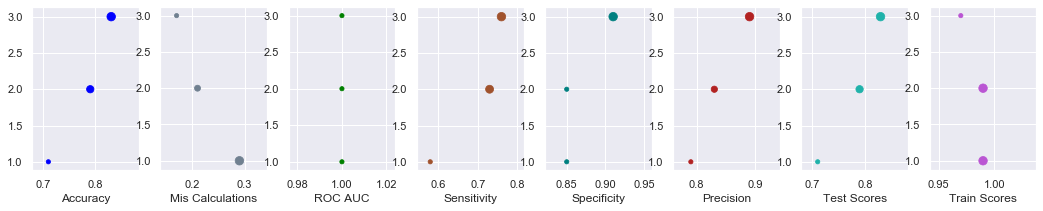

In [32]:
##Visualizing the scores for the best parameter selected above - ROW 4 parameter
scores = {x:[best_scores[y][4][2][x] for y in best_scores] for x in best_scores["1"][4][2]}
display_scores(scores, 200)

In [154]:
## now get the co-related words using the beast parameter model for run 1
run = 1
evolution_sub_clean_df = pd.read_csv("./datasets/evolution_sub_clean_" + str(run) + ".csv")
creation_sub_clean_df = pd.read_csv("./datasets/creation_sub_clean_" + str(run) + ".csv")
all_data_df = combine(evolution_sub_clean_df, creation_sub_clean_df) 

##Only considering text columns -> title + selftext + columns
get_full_row(all_data_df, feature_sets["3"]) ##only using feature set 7

##splitting the data
X = all_data_df["full_row"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [155]:
# 'classifier__C': 0.01,
#   'classifier__max_iter': 500,
#   'classifier__penalty': 'l2',
#   'vectorizer__max_df': 1.0,
#   'vectorizer__max_features': 3000,
#   'vectorizer__min_df': 1,
#   'vectorizer__ngram_range': (1, 4),
#   'vectorizer__stop_words': 'english'
tvec = TfidfVectorizer(max_features=3000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,4),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=500)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.8283582089552238


In [156]:
best_model = gs_log_reg.best_estimator_

In [157]:
sum_words = train_bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tvec.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=["words", "frequency"])
words_df["coefficient"] = best_model.coef_[0]

In [158]:
#looking at posts by looking at the max times its apearing on the posts.
#list of top recurring words
words_df.sort_values(by="frequency", ascending=False)[:20]

,words,frequency,coefficient
28,evolution,6.296939,0.091675
182,like,3.185824,0.003665
199,life,3.162475,0.026764
32,species,2.959019,0.046250
5,earth,2.940002,-0.023822
441,god,2.921540,0.007211
453,creation,2.726082,0.019269
262,human,2.671409,-0.029530
956,debate,2.493957,0.011383
36,evolutionary,2.404983,-0.000919


In [159]:
#Looking at the top words/bag of words that co-relate to predict the target value
words_df[words_df["coefficient"].abs() > 0.04].sort_values(by="coefficient")

,words,frequency,coefficient
2609,bound deleterious average,0.014627,-0.338365
973,request,0.106817,-0.335485
1432,tissue,0.807506,-0.278520
1449,homo,0.358011,-0.276716
988,possible evolve,0.448665,-0.220337
...,...,...,...
462,bible version satire,0.174145,0.249933
952,home,0.168183,0.257802
1245,exactly,0.079987,0.276010
594,difference,0.137189,0.359832


#### Problems identified by observing the above values

##### The above shows how the top appearing words are corelated to successfully determining if the post is from Creation or not. In my case, I have assigned 1 to Creation nd 0 to Evolution posts

In [160]:
##predicting all the values
all_data_df["y_hat"] = best_model.predict(tvec.transform(X))

In [161]:
##How many went wrong??
all_data_df[all_data_df["y"] != all_data_df["y_hat"]].shape

(14, 16)

In [162]:
# How many went right?
all_data_df[all_data_df["y"] == all_data_df["y_hat"]].shape

(186, 16)

In [163]:
#actual no of 1's and 0's
all_data_df["y"].value_counts()

1    100
0    100
Name: y, dtype: int64

In [164]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

0    108
1     92
Name: y_hat, dtype: int64

So this model predicted 108 posts as evolution and 92 as creations

In [75]:
#All the posts that were mis calculated
all_data_df.loc[(all_data_df["y"] != all_data_df["y_hat"]), ["subreddit", "title", "full_link", "y","y_hat"]]

,subreddit,title,full_link,y,y_hat
57,evolution,"evolutionarily,ancient,iron,sulfur,clusters,co...",https://www.reddit.com/r/evolution/comments/er...,0,1
59,evolution,"legendary,giant,squid,genome,revealed,,,myster...",https://www.reddit.com/r/evolution/comments/eq...,0,1
68,evolution,"makes,mutations,evolution,,random,,",https://www.reddit.com/r/evolution/comments/eq...,0,1
0,Creation,"unreasonable,effectiveness,mathematics,natural...",https://www.reddit.com/r/Creation/comments/evg...,1,0
2,Creation,"population,growth,matches,bible,dna,clock",https://www.reddit.com/r/Creation/comments/evd...,1,0
6,Creation,"know,read,,peaked,interest,",https://www.reddit.com/r/Creation/comments/euh...,1,0
28,Creation,"berean,archive",https://www.reddit.com/r/Creation/comments/erx...,1,0
33,Creation,"discover,interview,,lynn,margulis,says,controv...",https://www.reddit.com/r/Creation/comments/eqk...,1,0
34,Creation,"atlantic,,,never,taught,humans,came",https://www.reddit.com/r/Creation/comments/eqj...,1,0
36,Creation,",vestigial,organs,evolution,,remember,reading,...",https://www.reddit.com/r/Creation/comments/eqg...,1,0


# LEMMATIZING

In [128]:
## Trying to improve the score by using lema
all_data_df["lemma"] = all_data_df['full_row'].map(lemmatize)

In [129]:
##splitting the data
X = all_data_df["lemma"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [130]:
tvec = TfidfVectorizer(max_features=3000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,4),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=500)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.7910447761194029


In [131]:
# The score did not improve
cross_val_score(log_reg, train_bag_of_words, y_train, cv=5).mean()

0.7906593406593407

In [132]:
all_data_df["y_hat"] = best_model.predict(tvec.transform(X))

In [133]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

0    107
1     93
Name: y_hat, dtype: int64

# STEMMER

In [140]:
## Trying to improve the score by using stemma
all_data_df["stemmer"] = all_data_df['full_row'].map(stemmer)

In [147]:
##splitting the data
X = all_data_df["stemmer"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [151]:
tvec = TfidfVectorizer(max_features=3000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,4),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=500)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.7985074626865671


In [152]:
all_data_df["y_hat"] = best_model.predict(tvec.transform(X))

In [153]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

1    146
0     54
Name: y_hat, dtype: int64

# NOTE ** Lemma and Stemmer , both made the scorse worse here. What matters is data

In [166]:
# Using more data to see if the scores have improved
# 1000 posts each + 1000 comments each

# Running tests for all parameter combinations to see which one scored the best 1000

# for 1000 posts + 1000 comments from each subreddit

In [170]:
best_scores = get_best_scores_params("2")

/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Round 1 complete for feature set 1
Round 2 complete for feature set 1
Round 3 complete for feature set 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Round 4 complete for feature set 1
Round 5 complete for feature set 1
Round 6 complete for feature set 1


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", 

Round 1 complete for feature set 2
Round 2 complete for feature set 2
Round 3 complete for feature set 2
Round 4 complete for feature set 2
Round 5 complete for feature set 2
Round 6 complete for feature set 2


/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Round 1 complete for feature set 3
Round 2 complete for feature set 3
Round 3 complete for feature set 3
Round 4 complete for feature set 3
Round 5 complete for feature set 3
Round 6 complete for feature set 3


In [171]:
metrics_dict = {x:{y:None for y in all_params} for x in feature_sets}
miss_calc_dict = {x:{y:None for y in all_params} for x in feature_sets}

In [172]:
for features in feature_sets:
    for params in all_params:
        metrics_dict[features][params] = best_scores[features][params][0]
for features in feature_sets:
    for params in all_params:
        miss_calc_dict[features][params] = best_scores[features][params][2]['Mis Calculations']

In [173]:
pd.DataFrame(metrics_dict).style.apply(highlight_max)

,1,2,3
1,0.73,0.78,0.78
2,0.74,0.78,0.76
3,0.64,0.64,0.65
4,0.73,0.79,0.79
5,0.67,0.69,0.7
6,0.64,0.71,0.7


In [174]:
##best score from the above board, looking at the Scores in details
best_scores["3"][4]

[0.79,
 {'classifier__C': 0.1,
  'classifier__max_iter': 500,
  'classifier__penalty': 'l2',
  'vectorizer__max_df': 1.0,
  'vectorizer__max_features': 5000,
  'vectorizer__min_df': 1,
  'vectorizer__ngram_range': (1, 3),
  'vectorizer__stop_words': 'english'},
 {'No of evolution posts': 330,
  'No of Creation posts': 330,
  'No of predicted evolution posts': 321,
  'No of predicted creations posts': 339,
  'Baseline accuracy%': 0.5,
  'Train Scores': 0.89,
  'Test Scores': 0.8,
  'Accuracy': 0.8,
  'Mis Calculations': 0.2,
  'Sensitivity': 0.82,
  'Specificity': 0.79,
  'Precision': 0.8,
  'ROC AUC': 1.0,
  'Fit Type': 'Overfit'}]

In [175]:
#Highlighting the minimum miss calculations or the minimum difference between test and train scores
pd.DataFrame(miss_calc_dict).style.apply(highlight_min)

,1,2,3
1,0.23,0.22,0.21
2,0.24,0.21,0.23
3,0.32,0.36,0.33
4,0.25,0.21,0.2
5,0.3,0.3,0.26
6,0.33,0.22,0.26



Metrics for 2000 posts


,No of evolution posts,No of Creation posts,No of predicted evolution posts,No of predicted creations posts,Baseline accuracy%,Train Scores,Test Scores,Accuracy,Mis Calculations,Sensitivity,Specificity,Precision,ROC AUC,Fit Type
1,330,330,307,353,0.5,0.86,0.75,0.75,0.25,0.79,0.72,0.74,1.0,Overfit
2,330,330,317,343,0.5,0.89,0.79,0.79,0.21,0.81,0.77,0.78,1.0,Overfit
3,330,330,321,339,0.5,0.89,0.80,0.80,0.20,0.82,0.79,0.80,1.0,Overfit


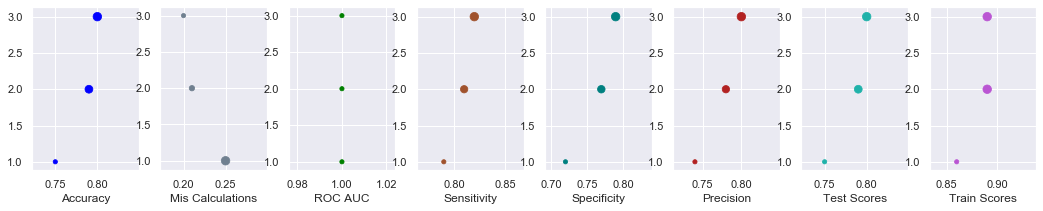

In [176]:
##Visualizing the scores for the best parameter selected above - ROW 4 parameter
scores = {x:[best_scores[y][4][2][x] for y in best_scores] for x in best_scores["1"][4][2]}
display_scores(scores, 2000)

In [494]:
## now get the co-related words using the beast parameter model for run 2
run = 2
evolution_sub_clean_df = pd.read_csv("./datasets/evolution_sub_clean_" + str(run) + ".csv")
creation_sub_clean_df = pd.read_csv("./datasets/creation_sub_clean_" + str(run) + ".csv")
all_data_df = combine(evolution_sub_clean_df, creation_sub_clean_df) 

##Only considering text columns -> title + selftext + columns
get_full_row(all_data_df, feature_sets["3"]) ##only using feature set 7

##splitting the data
X = all_data_df["full_row"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [505]:
tvec = TfidfVectorizer(max_features=6000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,5),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=600)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.7985074626865671


In [506]:
best_model = gs_log_reg.best_estimator_

In [507]:
sum_words = train_bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tvec.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=["words", "frequency"])
words_df["coefficient"] = best_model.coef_[0]

In [508]:
#looking at posts by looking at the max times its apearing on the posts.
#list of top recurring words
words_df.sort_values(by="frequency", ascending=False)[:20]

,words,frequency,coefficient
3,evolution,64.437083,-0.003179
63,like,22.194326,0.000703
139,human,21.005096,-0.000821
89,species,20.843108,0.001540
95,humans,20.330147,0.000643
11,evolutionary,20.169093,-0.000197
126,years,18.889070,0.000715
100,life,18.690405,-0.001171
22,science,18.244105,-0.001488
392,creation,17.915703,0.000259


In [509]:
#Looking at the top words/bag of words that co-relate to predict the target value
words_df[words_df["coefficient"].abs() > 0.04].sort_values(by="coefficient")

,words,frequency,coefficient
1771,transitional,1.678743,-0.060274
5145,current scientific,0.196088,-0.045009
1115,eventually,2.442765,0.046429


In [510]:
##predicting all the values
all_data_df["y_hat"] = best_model.predict(tvec.transform(X))

In [511]:
##How many went wrong??
all_data_df[all_data_df["y"] != all_data_df["y_hat"]].shape

(311, 17)

In [512]:
# How many went right?
all_data_df[all_data_df["y"] == all_data_df["y_hat"]].shape

(1689, 17)

In [513]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

1    1015
0     985
Name: y_hat, dtype: int64

In [514]:
## Trying to improve the score by using lema
all_data_df["lemma"] = all_data_df['full_row'].map(lemmatize)

In [515]:
##splitting the data
X = all_data_df["lemma"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [520]:
tvec = TfidfVectorizer(max_features=6000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,5),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=600)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.7910447761194029


In [521]:
## Trying to improve the score by using stemma
all_data_df["stemmer"] = all_data_df['full_row'].map(stemmer)

In [522]:
##splitting the data
X = all_data_df["stemmer"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [525]:
tvec = TfidfVectorizer(max_features=6000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,5),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegressionCV(random_state=42,
                               max_iter=600)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.7910447761194029


In [524]:
## Lemmatizing is not improving

# FINAL MODEL USED FOR CLASSIFYING DEBATE EVOLUTION

In [268]:
#Trying with 4000 posts
## now get the co-related words using the beast parameter model for run 2
run = 3
evolution_sub_clean_df = pd.read_csv("./datasets/evolution_sub_clean_" + str(run) + ".csv")
creation_sub_clean_df = pd.read_csv("./datasets/creation_sub_clean_" + str(run) + ".csv")
all_data_df = combine(evolution_sub_clean_df, creation_sub_clean_df) 
all_data_df.reset_index(inplace=True)

##Only considering text columns -> title + selftext + columns
get_full_row(all_data_df, feature_sets["3"]) ##only using feature set 7

##splitting the data
X = all_data_df["full_row"]
y = all_data_df["y"]
X_train, X_test, y_train, y_test = train_test_split(X,y, shuffle=True, test_size=0.33, stratify=y, random_state = 42)

In [269]:
tvec = TfidfVectorizer(max_features=5000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,3),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

log_reg = LogisticRegression(random_state=42,
                               max_iter=1000)

gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg.fit(train_bag_of_words, y_train)
print(gs_log_reg.best_score_)

0.8120240480961923


In [270]:
best_model = gs_log_reg.best_estimator_

In [271]:
best_model.score(train_bag_of_words, y_train)

0.9150300601202405

In [272]:
print(log_loss(y_test, best_model.predict(test_bag_of_words)))

6.5480856538761145


In [273]:
best_model.score(test_bag_of_words, y_test)

0.8104149715215623

In [274]:
sum_words = train_bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tvec.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=["words", "frequency"])
words_df["coefficient"] = best_model.coef_[0]

In [275]:
#looking at posts by looking at the max times its apearing on the posts.
#list of top recurring words
words_df.sort_values(by="frequency", ascending=False)[:20]

,words,frequency,coefficient
65,evolution,122.777086,-0.366453
430,like,41.966752,0.038246
275,species,41.291580,-0.202384
141,human,41.061350,0.493684
145,humans,39.749390,-0.079946
36,life,38.696162,0.083577
146,evolutionary,36.884825,0.121815
25,years,34.567527,0.129025
800,science,32.581020,0.048230
657,new,32.551487,-0.332295


In [276]:
#Looking at the top words/bag of words that co-relate to predict the target value
words_df[words_df["coefficient"] > 0.5][:20]

,words,frequency,coefficient
2,dr,14.740440,0.577194
13,recently,5.922311,0.687287
60,years ago,11.528503,1.064061
102,casual,0.753098,0.685475
103,explanation,7.482519,0.642215
115,ultimate,2.151800,0.648245
122,comments,8.737443,1.416079
156,gather,0.846111,0.588739
159,recognized,0.840553,0.545822
173,strong,3.031977,0.575386


In [277]:
words_df[words_df["coefficient"] < -0.5][:20]

,words,frequency,coefficient
63,saw,4.137701,-0.911342
129,app,1.274277,-0.579539
170,evolving,6.089586,-0.933814
171,quite,4.996711,-1.229193
174,survived,2.382616,-0.656496
175,asian,1.639546,-1.581659
179,ancient,20.803068,-0.536424
182,extreme,1.838239,-1.337052
187,bigger,2.925830,-0.539301
210,opposed,2.313960,-0.814191


In [278]:
## List of words whoes co-efficients are closer to each other
words_df[(words_df["coefficient"] > -0.3) & (words_df["coefficient"] < 0.3)]

,words,frequency,coefficient
0,creation,29.919812,-0.034223
1,member,1.956548,-0.174367
3,luke,1.563262,-0.166313
4,pm,1.353980,-0.199074
6,internet,2.245892,-0.109055
...,...,...,...
4995,masculine feminine,0.153749,0.118696
4996,inborn evolved,0.138374,0.266867
4997,transmembrane,0.532684,0.045418
4998,bubbles,0.117404,-0.024573


In [279]:
##predicting all the values
all_data_df["y_hat"] = best_model.predict(tvec.transform(X))

In [280]:
##How many went wrong??
all_data_df[all_data_df["y"] != all_data_df["y_hat"]].shape

(445, 17)

In [281]:
# How many went right?
all_data_df[all_data_df["y"] == all_data_df["y_hat"]].shape

(3279, 17)

In [282]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

0    2157
1    1567
Name: y_hat, dtype: int64

In [283]:
#actual no of 1's and 0's
all_data_df["y"].value_counts()

0    2000
1    1724
Name: y, dtype: int64

In [284]:
pred_proba = [i[1] for i in best_model.predict_proba(tvec.transform(X))]

pred_df = pd.DataFrame({'true_values': all_data_df["y"],
                        'pred_probs':pred_proba,
                        'pred_values': all_data_df["y_hat"]})

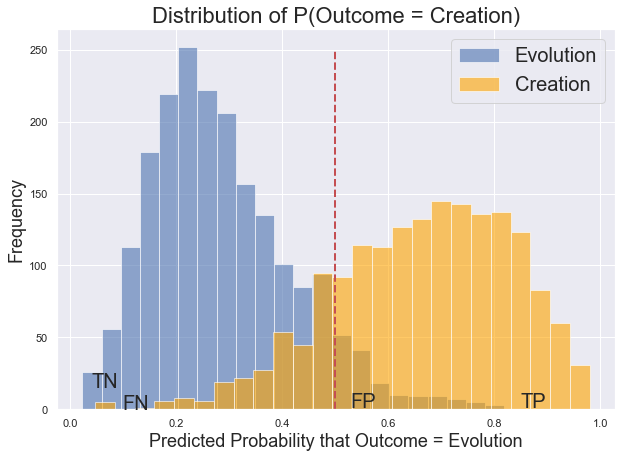

In [285]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Evolution')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Creation')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 250,
           color = 'r',
           linestyle = '--',
           linewidth=2)

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = Creation)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Evolution', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

# NOTE: TOO MUCH OVERLAP IN THE ABOVE DIAGRAM- LETS SEE WHERE THE OVER LAP IS??

In [286]:
fn_and_fp_list = list(pred_df[(pred_df["pred_probs"] > 0.4) & (pred_df["pred_probs"] < 0.6) & (pred_df["true_values"] != pred_df["pred_values"])].index)

In [287]:
all_data_df.loc[fn_and_fp_list, ["subreddit", "full_link", "y", "y_hat"]]

,subreddit,full_link,y,y_hat
6,evolution,https://www.reddit.com/r/evolution/comments/ev...,0,1
11,evolution,https://www.reddit.com/r/evolution/comments/eu...,0,1
78,evolution,https://www.reddit.com/r/evolution/comments/ep...,0,1
83,evolution,https://www.reddit.com/r/evolution/comments/ep...,0,1
90,evolution,https://www.reddit.com/r/evolution/comments/eo...,0,1
...,...,...,...,...
3661,Creation,https://www.reddit.com/r/Creation/comments/61g...,1,0
3676,Creation,https://www.reddit.com/r/Creation/comments/60n...,1,0
3686,Creation,https://www.reddit.com/r/Creation/comments/5zy...,1,0
3695,Creation,https://www.reddit.com/r/Creation/comments/5zp...,1,0


In [288]:
all_data_df["full_link"][6]

'https://www.reddit.com/r/evolution/comments/ev42pd/genesis_stereo_soundscape/'

In [289]:
all_data_df["full_link"][78]

'https://www.reddit.com/r/evolution/comments/epjvcx/wut_do/'

# NOTE:: INTERSETING ...... IN THE ABOVE LINK , THEY ARE TALKING ABOUT GENESIS  or has phrases LIKE "life arose by chance" IN EVOLUTION .. SO GO GO PREDICTION MODEL :)

In [291]:

# run = 3
# evolution_sub_clean_df = pd.read_csv("./datasets/evolution_sub_clean_" + str(run) + ".csv")
# creation_sub_clean_df = pd.read_csv("./datasets/creation_sub_clean_" + str(run) + ".csv")
# all_data_df = combine(evolution_sub_clean_df, creation_sub_clean_df) 
# all_data_df.reset_index(inplace=True)

# ##Only considering text columns -> title + selftext + columns
# get_full_row(all_data_df, feature_sets["3"]) ##only using feature set 7


# ##removing all the data which is confusning the model
all_data_df_n = all_data_df.drop(fn_and_fp_list)
all_data_df_n.reset_index(inplace=True)

In [292]:
##splitting the data
X_n = all_data_df_n["full_row"]
y_n = all_data_df_n["y"]

X_train, X_test, y_train, y_test = train_test_split(X_n,y_n, shuffle=True, test_size=0.33, stratify=y_n, random_state = 42)

In [293]:
tvec_n = TfidfVectorizer(max_features=5000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,6),
                       stop_words="english")

train_bag_of_words_n = tvec_n.fit_transform(X_train)
test_bag_of_words_n = tvec_n.transform(X_test)

log_reg_n = LogisticRegression(random_state=42,
                               max_iter=1000)

gs_log_reg_n = GridSearchCV(log_reg, param_grid={}, cv=5)
gs_log_reg_n.fit(train_bag_of_words_n, y_train)
print(gs_log_reg_n.best_score_)

0.8532986111111112


In [294]:
best_model = gs_log_reg_n.best_estimator_

In [295]:
best_model.score(train_bag_of_words_n, y_train)

0.9431423611111112

In [296]:
best_model.score(test_bag_of_words_n, y_test)

0.8644366197183099

In [302]:
pred_proba = [i[1] for i in best_model.predict_proba(tvec_n.transform(X))]
all_data_df["y_hat"] = best_model.predict(tvec_n.transform(X))

pred_df = pd.DataFrame({'true_values': all_data_df["y"],
                        'pred_probs':pred_proba,
                        'pred_values': all_data_df["y_hat"]})

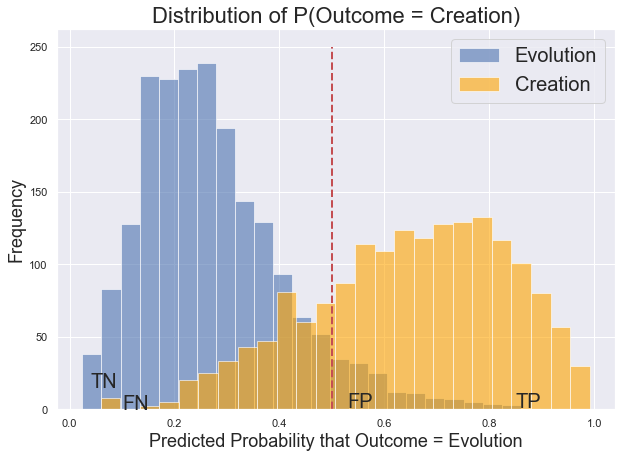

In [303]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Evolution')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Creation')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x = 0.5,
           ymin = 0,
           ymax = 250,
           color = 'r',
           linestyle = '--',
           linewidth=2)

# Add annotations for TN, FN, TP, FP.
plt.annotate(xy = (0.04, 15),
             s = 'TN',
             size = 20)

plt.annotate(xy = (0.1, 0),
             s = 'FN',
             size = 20)

plt.annotate(xy = (0.85, 1),
             s = 'TP',
             size = 20)

plt.annotate(xy = (0.53, 1),
             s = 'FP',
             size = 20)

# Label axes.
plt.title('Distribution of P(Outcome = Creation)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = Evolution', fontsize = 18)

# Create legend.
plt.legend(fontsize = 20);

# NOTE: GUESS THOSE WORDS CANNOT BE OMMITTED

# MOVING ON....

# LETS LOOK AT THE ROC AUC CURVE

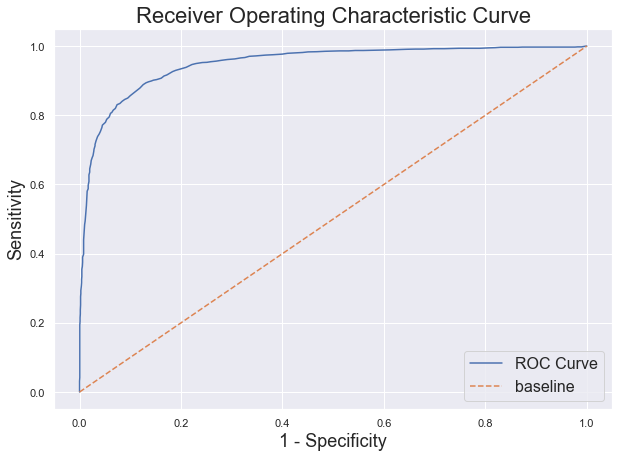

In [550]:
import numpy as np

# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)
    

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

In [627]:
tvec = TfidfVectorizer(max_features=5000,
                       min_df=1,
                       max_df=1.0,
                       ngram_range=(1,3),
                       stop_words="english")

train_bag_of_words = tvec.fit_transform(X_train)
test_bag_of_words = tvec.transform(X_test)

# log_reg = LogisticRegression(random_state=42,
#                                max_iter=1000)

# gs_log_reg = GridSearchCV(log_reg, param_grid={}, cv=5)
# gs_log_reg.fit(train_bag_of_words, y_train)
# print(gs_log_reg.best_score_)

vote = VotingClassifier([
    ('log_reg', LogisticRegressionCV(random_state=42)),
    ('ada', AdaBoostClassifier(random_state=42)),
    ('gb', GradientBoostingClassifier(random_state=42))
])
vote_params = {
    'ada__n_estimators': [50,75],
    'gb__n_estimators': [100,125]
}
gs = GridSearchCV(vote, param_grid=vote_params, cv=3)
# gs.fit(train_bag_of_words, y_train)
# print(gs.best_score_)
# gs.best_params_

In [611]:
best_model_vote = gs.best_estimator_

In [612]:
best_model_vote.score(train_bag_of_words, y_train)

0.8745490981963928

In [613]:
best_model_vote.score(test_bag_of_words, y_test)

0.7721724979658259

In [ ]:
###  Hmmmm.....did not do anything better... :(

In [615]:
from sklearn.svm import SVC
svc = SVC(gamma="scale")
# Fit support vector machine to training data.
svc.fit(train_bag_of_words, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [617]:
svc.score(train_bag_of_words, y_train)

0.9867735470941884

In [619]:
svc.score(test_bag_of_words, y_test)

0.8096013018714402

In [620]:
all_data_df["y_hat"] = svc.predict(tvec.transform(X))

In [621]:
##How many went wrong??
all_data_df[all_data_df["y"] != all_data_df["y_hat"]].shape

(267, 16)

In [622]:
##How many went right??
all_data_df[all_data_df["y"] == all_data_df["y_hat"]].shape

(3457, 16)

In [624]:
#actual no of 1's and 0's
all_data_df["y_hat"].value_counts()

0    2107
1    1617
Name: y_hat, dtype: int64

In [626]:
all_data_df["y"].value_counts()

0    2000
1    1724
Name: y, dtype: int64

# INVESTIGATING THE DebateEvolution subreddit. Checking which side the topics are leaning using my best model so far

In [439]:
# ##Score DebateEvolution 
# #Trying with 4000 posts
run = 3
debevo_sub_df = pd.read_csv("./datasets/DebateEvolution_submission_" + str(run) + ".csv")
debevo_sub_clean_df = pd.read_csv("./datasets/DebateEvolution_sub_clean_" + str(run) + ".csv")

##Only considering text columns -> title + selftext + columns
get_full_row(debevo_sub_clean_df, feature_sets["3"]) ##only using feature set 7

In [440]:
X = debevo_sub_clean_df["full_row"] ##only using feature set 7["full_row"]
X_bag_of_words = tvec.transform(X)
debevo_sub_clean_df["prediction"] = best_model.predict(X_bag_of_words)

In [441]:
debevo_sub_clean_df["prediction"].value_counts()

1    1288
0     712
Name: prediction, dtype: int64

#### Interesting to know that out of 2000 posts , 1314 are Creation heavy posts and 686 are evolution havy posts

In [442]:
debevo_sub_df["prediction"] = debevo_sub_clean_df["prediction"].map({0: "evolution", 1:"creation"})

In [443]:
debevo_sub_df.loc[debevo_sub_df["prediction"] == "creation","full_link"][1]

'https://www.reddit.com/r/DebateEvolution/comments/eurawo/pdp_runs_to_his_echo_chamber_to_argue_against/'

In [444]:
debevo_sub_df.loc[debevo_sub_df["prediction"] == "evolution","full_link"][6]

'https://www.reddit.com/r/DebateEvolution/comments/etwb4x/lets_break_something_part_4/'

In [445]:
debevo_sub_df.loc[debevo_sub_df["prediction"] == "evolution","full_link"][1996]

'https://www.reddit.com/r/DebateEvolution/comments/3f6qx0/programmed_cell_death_is_vital_to_life_but_whered/'

In [446]:
# debevo_sub_df.to_csv("./datasets/DebateEvolution_with_prediction.csv", index=False)

In [447]:
sum_words = X_bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in tvec.vocabulary_.items()]
words_df = pd.DataFrame(words_freq, columns=["words", "frequency"])
words_df["coefficient"] = best_model.coef_[0]

In [448]:
#looking at posts by looking at the max times its apearing on the posts.
#list of top recurring words
words_df.sort_values(by="frequency", ascending=False)[:20]

,words,frequency,coefficient
65,evolution,109.362652,-0.366453
608,removed,100.642652,-0.075712
560,creationists,55.494475,0.034007
517,evidence,49.323617,-0.684854
39,gt,47.746663,-0.180783
0,creation,46.395622,-0.034223
346,creationist,43.896022,0.016976
562,theory,38.674804,0.036378
3853,nbsp,35.797523,-1.068871
800,science,35.048861,0.048230


In [473]:
#Looking at the top words/bag of words that co-relate to predict the target value
words_df[words_df["coefficient"] > 0.5].sort_values(by="coefficient") ##more towards creation

,words,frequency,coefficient
3247,bio,3.262941,0.502038
4596,wikimedia,0.655533,0.502489
4728,grandmother,0.173067,0.505552
3599,moved,1.101374,0.506899
863,latest,1.612982,0.507245
...,...,...,...
1158,issues,3.054837,2.158521
4977,chocolate,0.000000,2.217608
4023,donkey,0.408247,2.597606
1798,know god,0.845151,2.919738


In [474]:
words_df[words_df["coefficient"] < -0.5].sort_values(by="coefficient") ##more towards evolution

,words,frequency,coefficient
1539,audience,0.608096,-2.856992
4273,regulation,1.008517,-2.642172
1570,cite,3.518904,-2.408180
1585,robert,0.489359,-2.031424
1586,revolution,0.739324,-1.901730
...,...,...,...
4245,bears,0.773741,-0.508398
4870,age spectrum,0.139233,-0.507816
756,elements,3.790788,-0.502086
280,prove,9.399975,-0.501317


In [450]:
###Look at the probabilities where it is high , slim and check the posts
lst_val = []
for i, (a,b) in enumerate(best_model.predict_proba(X_bag_of_words)):
#     lst_val.append(abs(a-b))
    if abs(a - b) < 0.05:
        lst_val.append(i)

In [451]:
lst_val[:10]

[28, 39, 43, 72, 93, 97, 108, 133, 139, 140]

In [452]:
row = 404
debevo_sub_df.loc[row,:]

subreddit                                              DebateEvolution
id                                                              bozn7h
author                                                  Joseph_Ratliff
author_flair_text                                                  NaN
author_fullname                                               t2_nd6ws
domain                                                   claremont.org
link_flair_text                                                    NaN
title                                                 Giving Up Darwin
selftext                                                           NaN
num_comments                                                         2
created_utc                                                 1557935663
full_link            https://www.reddit.com/r/DebateEvolution/comme...
prediction                                                    creation
Name: 404, dtype: object

In [453]:
debevo_sub_df["full_link"][row]

'https://www.reddit.com/r/DebateEvolution/comments/bozn7h/giving_up_darwin/'

   NEXT --> [Page 2](./Page_2.ipynb)